In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from scipy.signal import find_peaks
from scipy.signal import peak_widths

In [2]:
def get_image_list(directory:str, image_type:str) -> list:
    filenames = glob.glob(f"{directory}/*.{image_type}")
    
    return [os.path.normpath(f) for f in filenames]

def get_processed_image(image_path, trial, process_name, invert = False):
    filename = os.path.basename(image_path)
    image =  cv2.imread(f"./output/trial_{trial}/processed_images/masks/{process_name}/{os.path.basename(image_path)}", cv2.IMREAD_GRAYSCALE)
    
    if invert:
        image = cv2.bitwise_not(image)
        
    return image

def get_subdirectories(directory):
    return [f.path for f in os.scandir(directory) if f.is_dir()]

def get_process_names(directory):
    return [os.path.basename(f) for f in get_subdirectories(directory)]

def load_images_for_given_process(image_path, trial_number, process_name):
    """
        Load images from the given filenames. Returns raw image and the processed image.
        
        The processed image is inverted so that the lumen/stroma is black and the membrane as white.
        This is to aid in the contouring process, which sees the area of the image as the area within the contour.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    p_image = cv2.imread(f"./output/trial_{trial_number}/processed_images/masks/{process_name}/{os.path.basename(image_path)}", cv2.IMREAD_GRAYSCALE)
    

    return image, cv2.bitwise_not(p_image)


import pandas as pd
import os

def get_original_filename(image_name, metadata_filename):
    """
        Search the metadata file for the original filename of the image that the strip was taken from, and return it.
    """
    image_metadata = pd.read_csv(metadata_filename)
    
    image_name = os.path.normpath(image_name)
    print(image_name)
    
    #output\trial_1\rois\strip_101.png
    image_name = os.path.basename(image_name)
    
    #strip_101.png
    strip_number = int(image_name.strip(".png").split("_")[1])
    
    
    # if image_metadata is none, thorw an error
    if image_metadata is None:
        raise ValueError("Image metadata is None")
    
    image_df = image_metadata[image_metadata['strip'] == strip_number].to_dict(orient='records')[0]
    return image_df["filename"]


def get_image_conversion_factors(image_name:str, conversion_df_filename: str, metadata_filename: str) -> dict:
    """ 
        Returns the dict with the nm_per_pixel and pixel_per_nm values for the given image name.
    """

    image_raw_filename = get_original_filename(image_name, metadata_filename)

    conversion_df = pd.read_csv(conversion_df_filename)
    
    conversion_df['filename'] = conversion_df['filename'].map(os.path.normpath)
    
    filename = os.path.normpath(image_raw_filename)#
    
    image_conversion_factors = conversion_df[conversion_df['filename'] == filename].to_dict(orient='records')[0]

    return {"nm_per_pixel": image_conversion_factors['nm_per_pixel'], "pixel_per_nm": image_conversion_factors['pixel_per_nm']}


def convert_nm_to_pixel(nm_value, nm_per_pixel):
    return nm_value / nm_per_pixel

def convert_pixel_to_nm(pixel_value, pixel_per_nm):
    return pixel_value / pixel_per_nm

def create_image_dict(image_name, metadata:dict) -> dict:
    """ retrieve the images for the given image name, trial number and process name, and return them in a dictionary """
        
    # p_image has the lumen/stroma as black and the membrane as white. We want to extract the membrane
    image, p_image = load_images_for_given_process(image_name, metadata["trial_number"], metadata["process_name"])

    # start with a black image for saving the membrane contours to
    membrane_image = np.zeros_like(p_image)    
    
    # create the contours based on the processed image
    membrane_contours = get_filtered_contours(p_image, min_area=100, max_area=np.Infinity)
    
    # draw the contours on the image
    cv2.drawContours(membrane_image, membrane_contours, -1, (255, 0, 0), -1)
    
    # invert the image so that the membrane is white and the lumen/stroma is black
    lumen_image = cv2.bitwise_not(membrane_image)

    convert_dict = get_image_conversion_factors(image_name, metadata["conversion_df_filename"], metadata["metadata_filename"])

    strip_name = os.path.basename(image_name).split(".png")[0]

    image_dict = {
        "strip_name": strip_name,
        "image_name": image_name,
        "image": image,
        "p_image": p_image,
        "lumen": lumen_image,
        "membrane": membrane_image,
        "nm_per_pixel": convert_dict["nm_per_pixel"],
        "pixel_per_nm": convert_dict["pixel_per_nm"]
    }
    
    return image_dict


def get_filtered_contours(image, min_area=0, max_area=np.Infinity, contour_method : int = cv2.RETR_EXTERNAL, contour_approximation : int = cv2.CHAIN_APPROX_SIMPLE):
    """
        Calculate the contours of the white regions of the image, then filter the results
        according to the given min and max area. Return the filtered contours.
        
    """
    
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    contours, hierarchy = cv2.findContours(image, contour_method, contour_approximation)


    return [c for c in contours if min_area < cv2.contourArea(c) < max_area]

def calculate_peak_data(image_dict:dict, metadata: dict, peak_type: str = "membrane") -> dict:
    """
        Calculate the peaks and widths of the membrane histogram, and return the data in a dict.
    """
    image_name = image_dict["image_name"]
    nm_per_pixel = image_dict['nm_per_pixel']
    pixel_per_nm = image_dict['pixel_per_nm']
    input_image = image_dict[peak_type]
    chosen_height = metadata["chosen_height"]

    peak_data = {}

    histogram = np.sum(input_image, axis=1)

    peaks, _ = find_peaks(histogram)

    avg_peak_height = np.mean(histogram[peaks])
    half_height = avg_peak_height * chosen_height

    chosen_rel_height = half_height / avg_peak_height

    peaks, _ = find_peaks(histogram, height=half_height)

    results_half = peak_widths(histogram, peaks, rel_height=chosen_height)

    widths, width_heights, left_ips, right_ips = results_half

    peak_data["peaks"] = peaks
    peak_data["histogram"] = histogram
    peak_data["avg_peak_height"] = avg_peak_height
    peak_data["half_height"] = half_height
    peak_data["chosen_rel_height"] = chosen_rel_height
    peak_data["results_half"] = results_half
    peak_data["widths"] = widths
    peak_data["width_heights"] = width_heights
    peak_data["left_ips"] = left_ips
    peak_data["right_ips"] = right_ips
    
    return peak_data

In [3]:
# define some functions to help with extracting the peaks and widths from the histograms
selected_trial = 1

metadata = {"trial_number": selected_trial,
            "process_name": "otsu_thresholding_blurred_not_equalized",
            "conversion_df_filename" : "./metadata/image_scale_conversion.csv",
            "metadata_filename" : "output/trial_1/081624_rois_metadata_bignine.csv",
            "images": get_image_list(directory=f"./output/trial_{selected_trial}/rois", image_type="png"),
            "chosen_height": 0.5,
            }


# setup the output
os.makedirs(f"./output/trial_{metadata["trial_number"]}/histograms/", exist_ok=True)

# verify we are loading the correct images
print(metadata["images"])

['output\\trial_1\\rois\\strip_101.png', 'output\\trial_1\\rois\\strip_106.png', 'output\\trial_1\\rois\\strip_134.png', 'output\\trial_1\\rois\\strip_135.png', 'output\\trial_1\\rois\\strip_161.png', 'output\\trial_1\\rois\\strip_176.png', 'output\\trial_1\\rois\\strip_187.png', 'output\\trial_1\\rois\\strip_229.png', 'output\\trial_1\\rois\\strip_232.png']


In [21]:

def calculate_grana_height(membrane_data:dict) -> float:
    """
        Calculate the height of the grana stacks in px. Take the min of the left_ips and the
        max of the right_ips.
    """
        # Left ips: [24.36666667 34.17391304 48.41463415 62.39393939 77.22580645 91.818181[82]
    # Right ips: [29.16666667 43.40625    57.33333333 71.04166667 86.8        96.5       ]
    return np.max(membrane_data["right_ips"]) - np.min(membrane_data["left_ips"])


def calculate_repeat_distance(lumen_data:dict) -> float:
    """
        Calculate the distance between the lumen peaks in px. Return the average distance
        between the peaks.
    """
    
    peaks = lumen_data["peaks"]
    
    # calculate the differences between the peaks
    repeat_distances = np.diff(peaks)
    
    return np.mean(repeat_distances)

# calculate_values(membrane_data, lumen_data, image_dict, metadata)/
def calculate_grana_values(membrane_data: dict, lumen_data: dict, image_dict: dict) -> dict:
    """ 
        Take the peaks and widths of the membrane and lumen histograms, and return the grana values.
        peaks data:
            peak_data["peaks"] = peaks
            peak_data["histogram"] = histogram
            peak_data["avg_peak_height"] = avg_peak_height
            peak_data["half_height"] = half_height
            peak_data["chosen_rel_height"] = chosen_rel_height
            peak_data["results_half"] = results_half
            peak_data["widths"] = widths
            peak_data["width_heights"] = width_heights
            peak_data["left_ips"] = left_ips
            peak_data["right_ips"] = right_ips
        image_dict:
            "image_name": image_name,
            "image": image,
            "p_image": p_image,
            "lumen": lumen_image,
            "membrane": membrane_image,
            "nm_per_pixel": convert_dict["nm_per_pixel"],
            "pixel_per_nm": convert_dict["pixel_per_nm"]
    """
    # strip,grana_height,num_lumen,repeat_distance

    
    grana_values = {
        "strip_num": os.path.basename(image_dict["image_name"]).strip(".png").strip("strip_"),
        "image_name": image_dict["image_name"],
        "image_dict": image_dict,
        "membrane_data": membrane_data,
        "lumen_data": lumen_data,
        "grana_height": calculate_grana_height(membrane_data),
        "num_lumen": len(lumen_data["peaks"]),
        "repeat_distance": calculate_repeat_distance(lumen_data),
    }
    
    return grana_values



def plot_histogram(grana_data: dict, metadata:dict, peak_type: str = "membrane"):

    image_dict = grana_data["image_dict"]
    membrane_data = grana_data["membrane_data"]
    lumen_data = grana_data["lumen_data"]
    strip_name = image_dict["strip_name"]
    process_name = metadata["process_name"]
    trial_number = metadata["trial_number"]
    
    if peak_type == "membrane":
        peaks = membrane_data["peaks"]
        histogram = membrane_data["histogram"]
        half_height = membrane_data["half_height"]
        left_ips = membrane_data["left_ips"]
        right_ips = membrane_data["right_ips"]
    else:
        peaks = lumen_data["peaks"]
        histogram = lumen_data["histogram"]
        half_height = lumen_data["half_height"]
        left_ips = lumen_data["left_ips"]
        right_ips = lumen_data["right_ips"]

    ################ Plot it ################
    # plot the histogram, but make sure the background is white
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150, facecolor='w')
    plt.plot(histogram)

    # plot the peaks, and then a green line dropping down
    plt.plot(peaks, histogram[peaks], "x")
    for peak in peaks:
        plt.plot([peak, peak], [0, histogram[peak]], "--g")
        
    # use the left and right interpolated points to plot the width of the peak
    for left_ip, right_ip in zip(left_ips, right_ips):
        plt.plot([left_ip, right_ip], [half_height, half_height], "-r")

    plt.title(f"{peak_type} Histogram\n{image_name}")
    plt.savefig(f"./output/trial_{trial_number}/histograms/{strip_name}_{peak_type}_histogram.png")
    plt.show()
    

In [22]:
def export_grana_values(grana_data):
    return {
        "strip": grana_values['strip_num'],
        "grana_height" : grana_values['grana_height'],
        "grana_height_nm": grana_values['grana_height'] * grana_values['image_dict']['nm_per_pixel'],
        "num_lumen": grana_values['num_lumen'],
        "repeat_distance": grana_values['repeat_distance'],
        "repeat_distance_nm": grana_values['repeat_distance'] * grana_values['image_dict']['nm_per_pixel'],
        "px_per_nm": grana_values['image_dict']['pixel_per_nm'],
        "nm_per_px": grana_values['image_dict']['nm_per_pixel'],
    }
    

all_grana = []
all_grana_data= []

for image_number, image_name in enumerate(metadata["images"]):

    # load the images in their dict: image, p_image, lumen_image, membrane_image    
    image_dict = create_image_dict(image_name, metadata)

    membrane_data = calculate_peak_data(image_dict, metadata, peak_type="membrane")
    lumen_data = calculate_peak_data(image_dict, metadata, peak_type="lumen")
    
    grana_values = calculate_grana_values(membrane_data, lumen_data, image_dict)
    
    all_grana_data.append(export_grana_values(grana_values))
    all_grana.append(grana_values)    
    

# create a dataframe from the grana data
grana_df = pd.DataFrame(all_grana_data)
grana_df.to_csv(f"./output/trial_{metadata['trial_number']}/grana_data.csv", index=False)

output\trial_1\rois\strip_101.png
output\trial_1\rois\strip_106.png
output\trial_1\rois\strip_134.png
output\trial_1\rois\strip_135.png
output\trial_1\rois\strip_161.png
output\trial_1\rois\strip_176.png
output\trial_1\rois\strip_187.png
output\trial_1\rois\strip_229.png
output\trial_1\rois\strip_232.png


# Plot the membrane histogram and its parameters

Processing output\trial_1\rois\strip_101.png


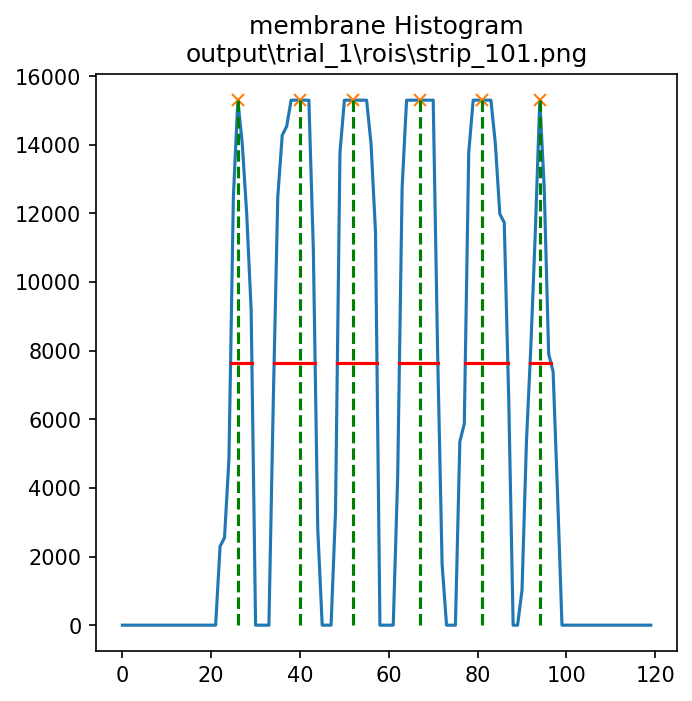

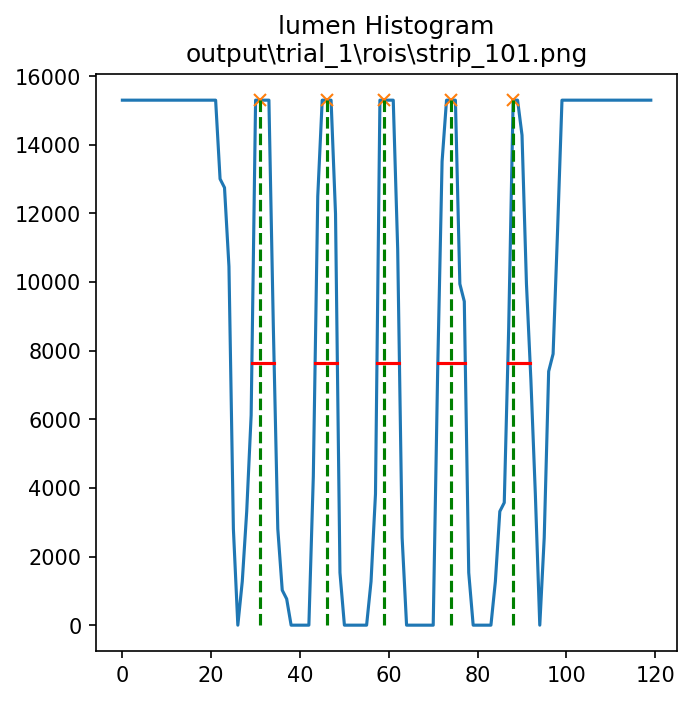

strip_101 grana height: 72.13333333333333 px
Left ips: [24.36666667 34.17391304 48.41463415 62.39393939 77.22580645 91.81818182]
Right ips: [29.16666667 43.40625    57.33333333 71.04166667 86.8        96.5       ]
Processing output\trial_1\rois\strip_106.png


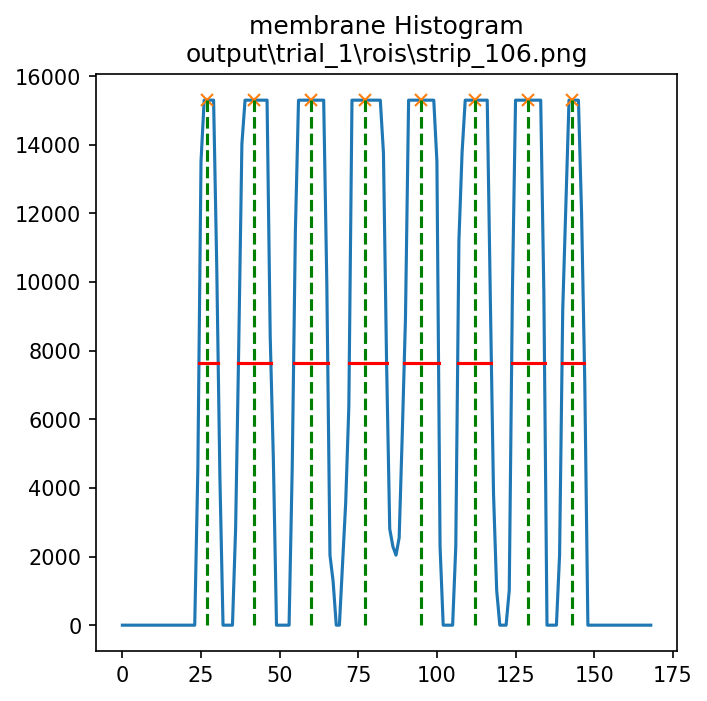

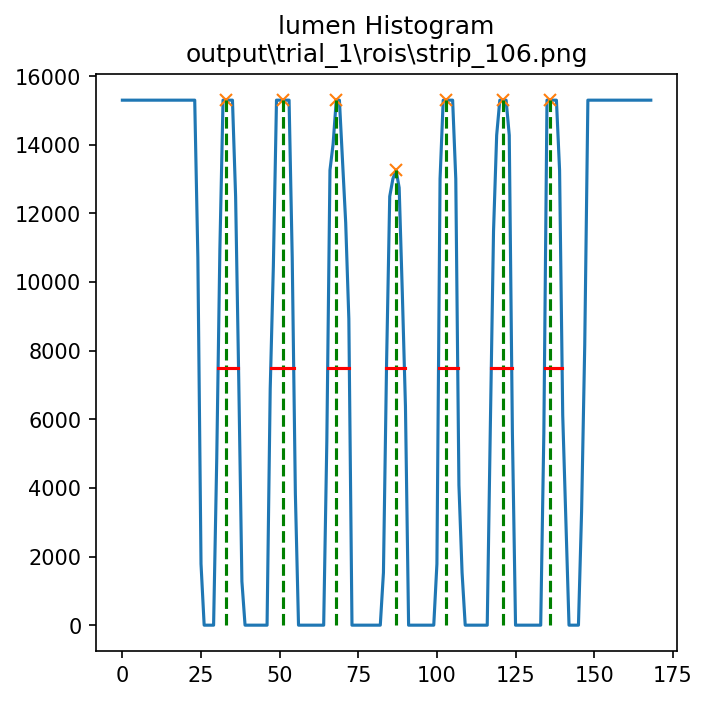

strip_106 grana height: 122.55187969924812 px
Left ips: [ 24.34285714  36.9047619   54.44444444  72.14285714  89.61538462
 106.6        123.76470588 139.78571429]
Right ips: [ 30.45833333  47.21428571  65.29032258  84.         100.52272727
 117.31818182 134.21052632 146.89473684]
Processing output\trial_1\rois\strip_134.png


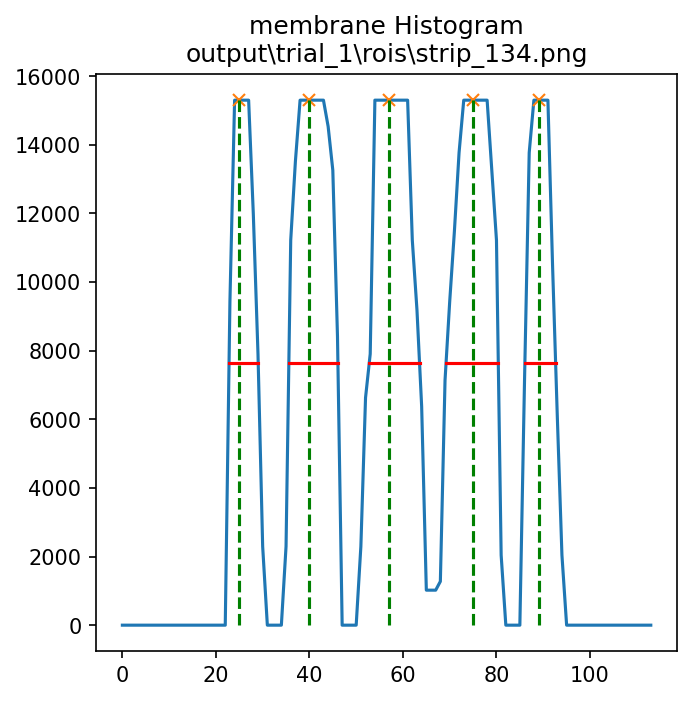

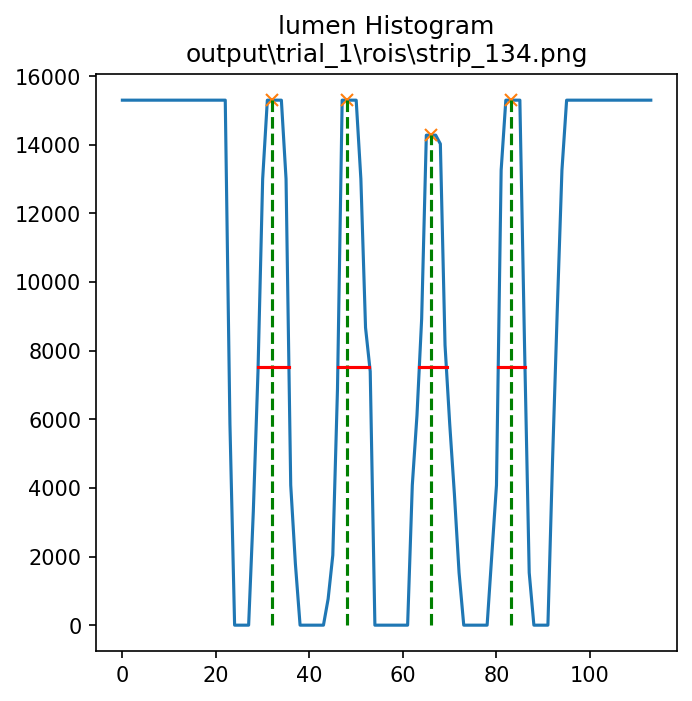

strip_134 grana height: 69.8362480127186 px
Left ips: [22.81081081 35.6        52.8        69.22222222 86.07692308]
Right ips: [29.04545455 46.09090909 63.54545455 80.38888889 92.64705882]
Processing output\trial_1\rois\strip_135.png


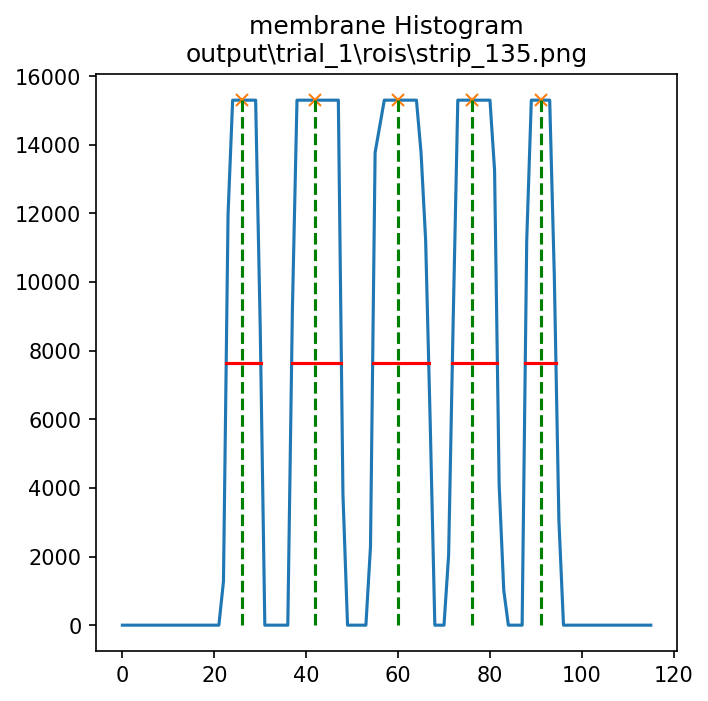

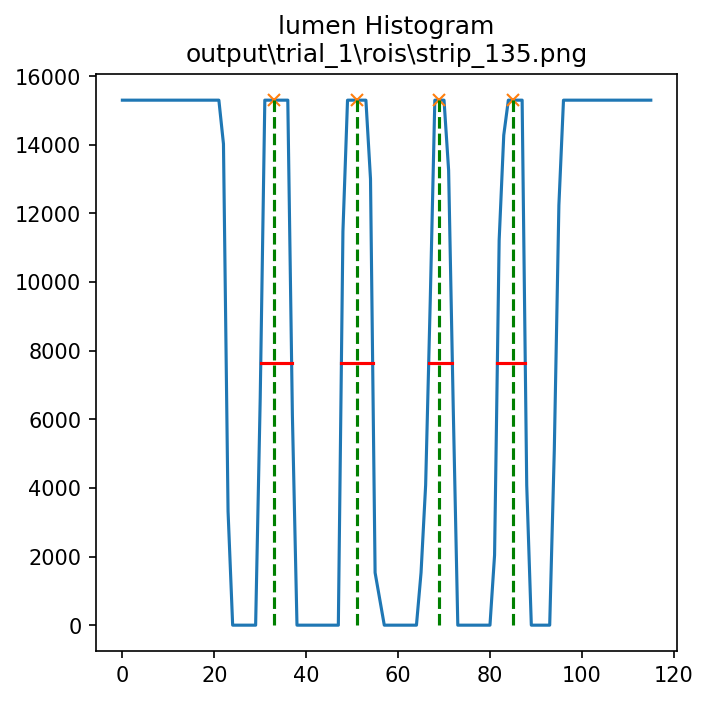

strip_135 grana height: 71.76190476190476 px
Left ips: [22.5952381  36.83333333 54.46666667 71.81481481 87.68181818]
Right ips: [30.11764706 47.66666667 66.66666667 81.61111111 94.35714286]
Processing output\trial_1\rois\strip_161.png


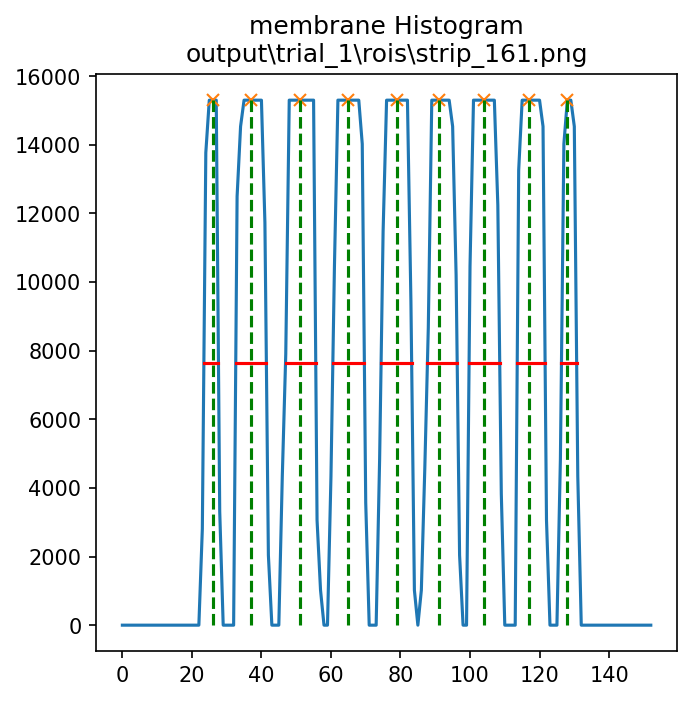

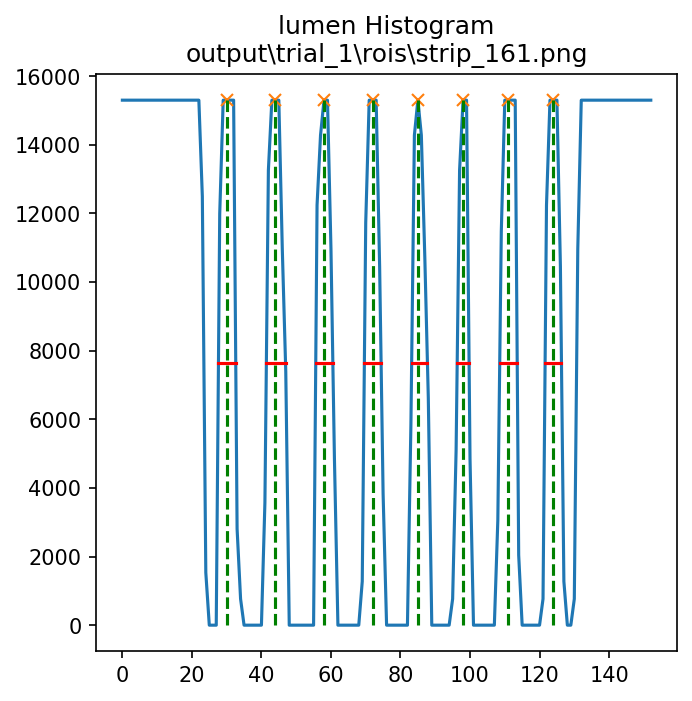

strip_161 grana height: 107.23313953488373 px
Left ips: [ 23.44186047  32.6122449   46.92857143  60.54166667  74.42307692
  87.75        99.73170732 113.57692308 126.30555556]
Right ips: [ 27.63829787  41.42105263  55.625       69.6097561   83.21212121
  96.3125     108.54545455 121.6        130.675     ]
Processing output\trial_1\rois\strip_176.png


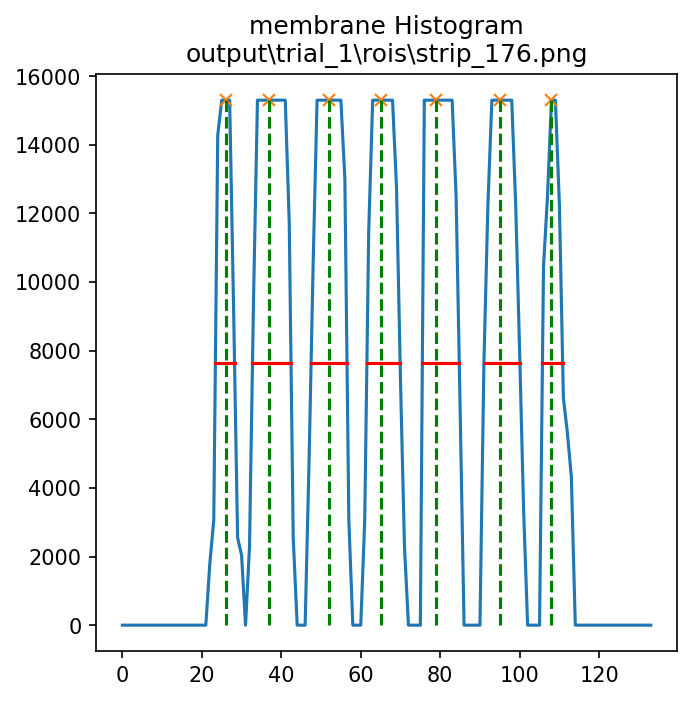

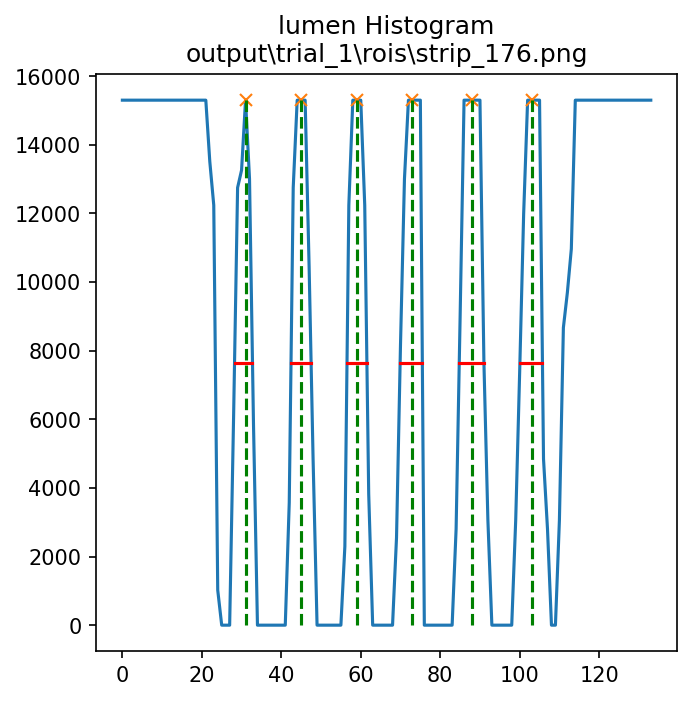

strip_176 grana height: 87.4090909090909 px
Left ips: [ 23.40909091  32.75        47.5         61.54545455  75.5
  91.         105.73170732]
Right ips: [ 28.23076923  42.44444444  56.53846154  69.90909091  84.79166667
 100.05555556 110.81818182]
Processing output\trial_1\rois\strip_187.png


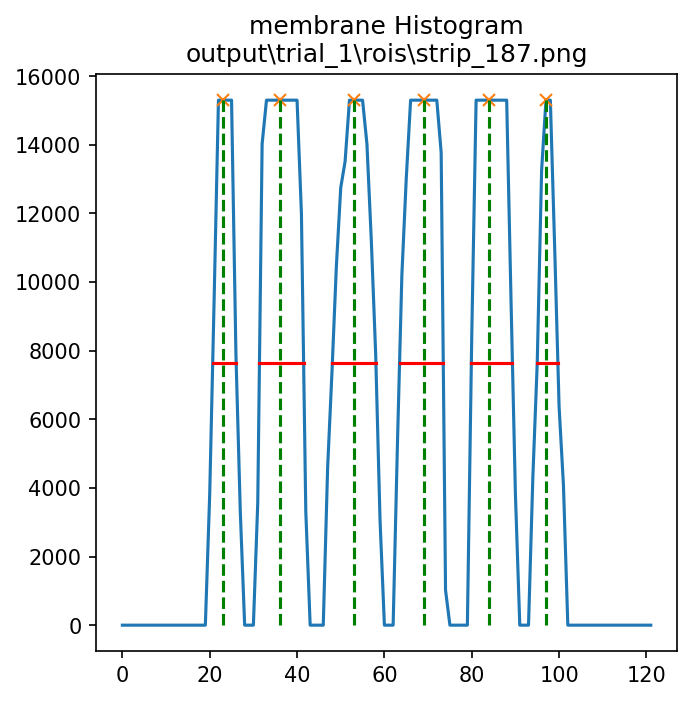

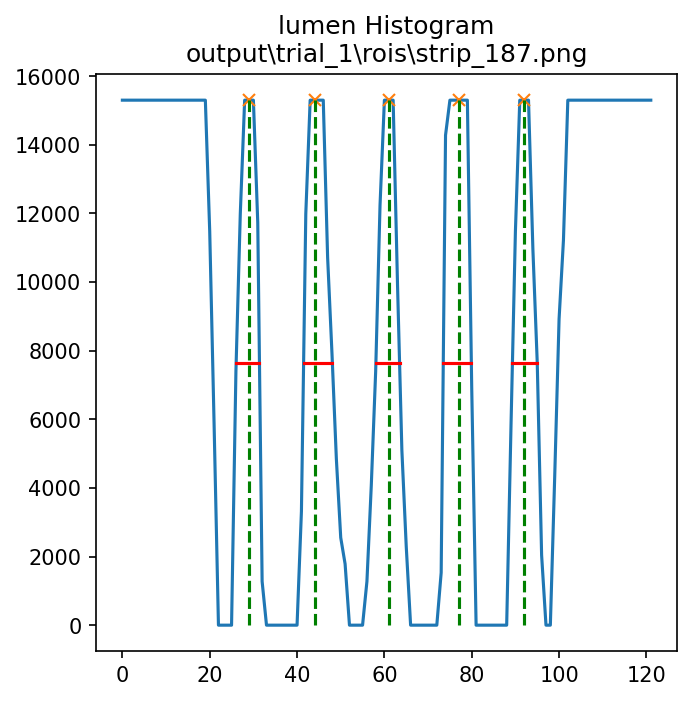

strip_187 grana height: 79.04040404040404 px
Left ips: [20.68181818 31.3902439  48.08333333 63.47368421 79.90909091 95.        ]
Right ips: [26.05555556 41.5        58.05263158 73.48       89.31818182 99.72222222]
Processing output\trial_1\rois\strip_229.png


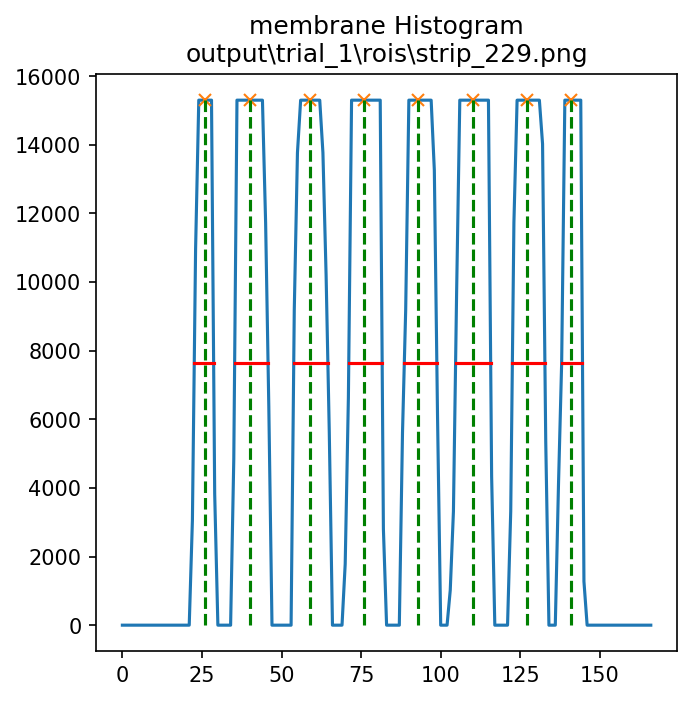

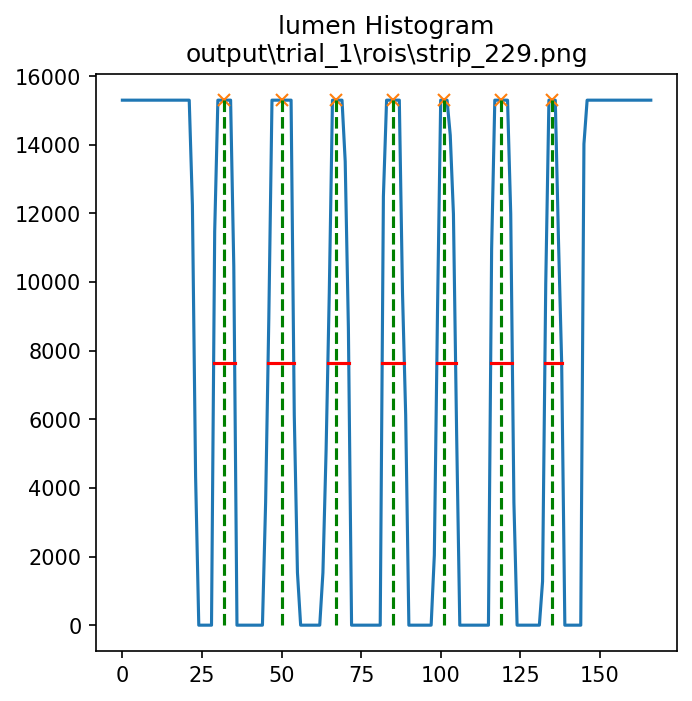

strip_229 grana height: 121.96480938416421 px
Left ips: [ 22.58064516  35.26829268  53.83333333  71.11764706  88.57142857
 104.68       122.51515152 138.        ]
Right ips: [ 28.66666667  45.76190476  64.55555556  81.6122449   98.78571429
 115.69767442 132.73529412 144.54545455]
Processing output\trial_1\rois\strip_232.png


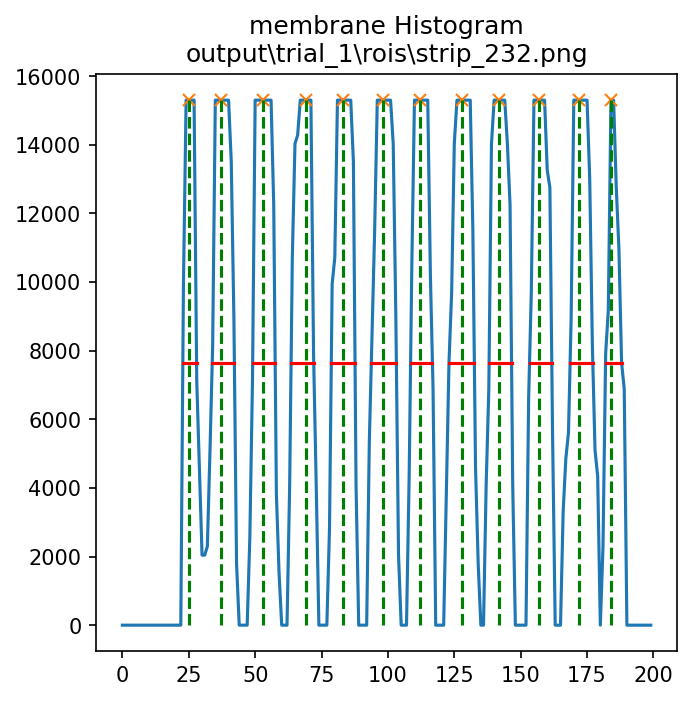

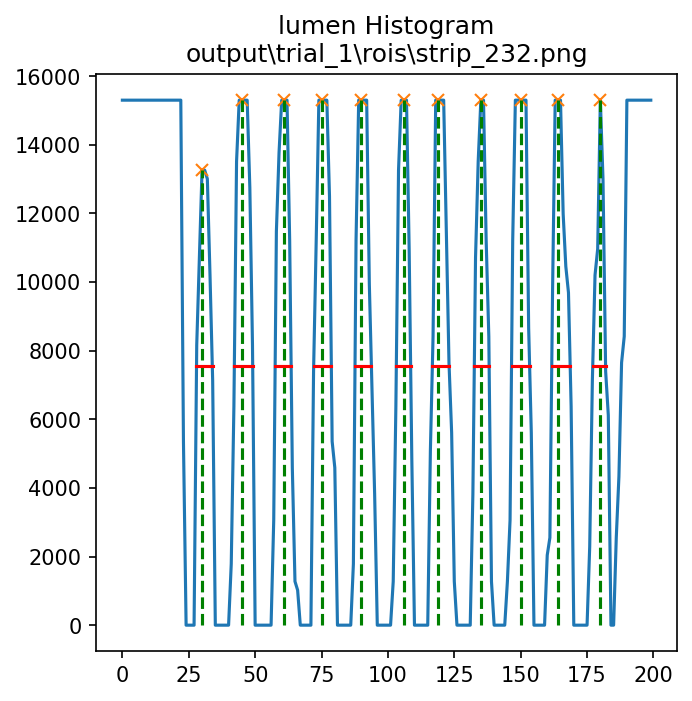

strip_232 grana height: 165.23076923076923 px
Left ips: [ 22.76923077  33.83333333  49.0625      63.53846154  78.67857143
  93.75       108.54166667 123.         138.10714286 153.33333333
 168.61538462 181.95454545]
Right ips: [ 27.9375      42.17857143  57.54545455  72.06666667  87.62162162
 103.18518519 116.76923077 132.55555556 146.5625     161.71428571
 177.16666667 188.        ]


In [23]:
for i, grana_data in enumerate(all_grana):
    image_dict = grana_data["image_dict"]
    membrane_data = grana_data["membrane_data"]
    lumen_data = grana_data["lumen_data"]
    image_name = image_dict["image_name"]
    strip_name = image_dict["strip_name"]
    process_name = metadata["process_name"]
    
    print(f"Processing {image_dict['image_name']}")
    
    plot_histogram(grana_data, metadata, peak_type="membrane")
    plot_histogram(grana_data, metadata, peak_type="lumen")
    
    # calculate the grana height
    grana_height = calculate_grana_height(membrane_data)
    print(f"{strip_name} grana height: {grana_height} px")
    
    left_ips = membrane_data["left_ips"]
    right_ips = membrane_data["right_ips"]
    print(f"Left ips: {left_ips}")
    print(f"Right ips: {right_ips}")
    
    